# Diffusion Model 实践
这是一个简单的Diffusion Model实践任务：在 MNIST 数据集上训练一个扩散模型（Diffusion Model），使用UNet

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # 在 Jupyter 环境中使用 tqdm.notebook
import math
import matplotlib.pyplot as plt # 导入 matplotlib


In [19]:

# --------------- 参数设置 ---------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用的设备: {device}")

IMG_SIZE = 28 # MNIST 图像大小
BATCH_SIZE = 128 # 批量大小
EPOCHS = 20 # 训练轮数 (可以根据需要调整，10轮可以看到初步效果，20轮以上效果更好)
LR = 1e-3 # 学习率

# 扩散模型参数
TIMESTEPS = 300 # 时间步长
BETA_START = 0.0001 # beta 起始值
BETA_END = 0.02 # beta 结束值


使用的设备: cuda


开始训练...


Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/20 完成, 平均损失: 0.0838


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/20 完成, 平均损失: 0.0543


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/20 完成, 平均损失: 0.0507


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/20 完成, 平均损失: 0.0482


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/20 完成, 平均损失: 0.0466


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/20 完成, 平均损失: 0.0456


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/20 完成, 平均损失: 0.0456


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/20 完成, 平均损失: 0.0447


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/20 完成, 平均损失: 0.0442


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/20 完成, 平均损失: 0.0440


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/20 完成, 平均损失: 0.0433


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/20 完成, 平均损失: 0.0434


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/20 完成, 平均损失: 0.0428


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/20 完成, 平均损失: 0.0428


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/20 完成, 平均损失: 0.0427


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/20 完成, 平均损失: 0.0424


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/20 完成, 平均损失: 0.0425


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/20 完成, 平均损失: 0.0419


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/20 完成, 平均损失: 0.0418


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/20 完成, 平均损失: 0.0416
训练完成!

尝试生成并显示一些图像...
开始采样生成图像...


采样步骤:   0%|          | 0/300 [00:00<?, ?it/s]

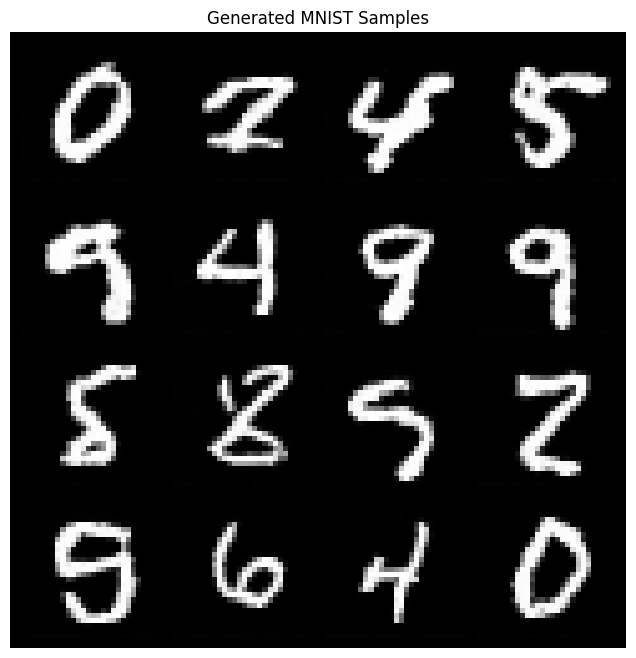

生成的图像样本已显示。


In [20]:

# --------------- 1. UNet 架构 ---------------

class SinusoidalPositionEmbeddings(nn.Module):
    """正弦位置嵌入，用于编码时间步 t"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    """基础卷积块"""
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up: # 上采样
            # 当 up=True 时, 输入 x 已经是拼接后的特征图
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else: # 下采样
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t_emb):
        # 时间嵌入
        time_emb = self.relu(self.time_mlp(t_emb))
        time_emb = time_emb[(..., ) + (None, ) * 2] # (B, C) -> (B, C, 1, 1)

        h = self.bnorm1(self.relu(self.conv1(x)))
        h = h + time_emb # 将时间信息融入特征
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SimpleUNet(nn.Module):
    """一个简化的 UNet 模型"""
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128, base_dim=64):
        super().__init__()
        self.time_emb_dim = time_emb_dim

        # 时间嵌入层
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # 初始卷积层
        self.init_conv = nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=1)

        # 下采样路径
        self.down1 = Block(base_dim, base_dim*2, time_emb_dim)      # 28x28 -> 14x14
        self.down2 = Block(base_dim*2, base_dim*4, time_emb_dim)    # 14x14 -> 7x7

        # 中间瓶颈层
        self.bot_conv1 = nn.Conv2d(base_dim*4, base_dim*8, kernel_size=3, padding=1) # 7x7 -> 7x7
        self.bot_conv2 = nn.Conv2d(base_dim*8, base_dim*8, kernel_size=3, padding=1) # 7x7 -> 7x7
        self.bot_conv3 = nn.Conv2d(base_dim*8, base_dim*4, kernel_size=3, padding=1) # 7x7 -> 7x7

        # 上采样路径
        # in_ch for Block is the channel size *after* concatenation
        self.up1 = Block(in_ch=base_dim*4 + base_dim*4, out_ch=base_dim*2, time_emb_dim=time_emb_dim, up=True) # 7x7 -> 14x14
        self.up2 = Block(in_ch=base_dim*2 + base_dim*2, out_ch=base_dim, time_emb_dim=time_emb_dim, up=True)   # 14x14 -> 28x28

        # 输出层
        # in_ch for out_conv is channel size *after* concatenation
        self.out_conv = nn.Conv2d(base_dim + base_dim, out_channels, kernel_size=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        x1 = self.init_conv(x) # (B, base_dim, 28, 28)

        d1 = self.down1(x1, t_emb) # (B, base_dim*2, 14, 14)
        d2 = self.down2(d1, t_emb) # (B, base_dim*4, 7, 7)

        b = self.bot_conv1(d2)
        b = self.bot_conv2(b)
        b = self.bot_conv3(b)  # (B, base_dim*4, 7, 7)

        u1_in = torch.cat((b, d2), dim=1) # (B, base_dim*4 + base_dim*4, 7, 7)
        u1 = self.up1(u1_in, t_emb)       # (B, base_dim*2, 14, 14)

        u2_in = torch.cat((u1, d1), dim=1) # (B, base_dim*2 + base_dim*2, 14, 14)
        u2 = self.up2(u2_in, t_emb)        # (B, base_dim, 28, 28)

        out_in = torch.cat((u2, x1), dim=1) # (B, base_dim + base_dim, 28, 28)
        out = self.out_conv(out_in)         # (B, out_channels, 28, 28)

        return out

# --------------- 2. 扩散模型辅助函数 ---------------

def linear_beta_schedule(timesteps, beta_start=BETA_START, beta_end=BETA_END):
    return torch.linspace(beta_start, beta_end, timesteps, device=device)

betas = linear_beta_schedule(TIMESTEPS)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def p_losses(denoise_model, x_start, t, noise=None, loss_type="l2"): # 通常使用 L2 loss
    if noise is None:
        noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()
    return loss

# --------------- 3. 数据准备 ---------------
transforms_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transforms_mnist)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# --------------- 4. 模型、优化器 ---------------
model = SimpleUNet(in_channels=1, out_channels=1, time_emb_dim=128, base_dim=64).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# --------------- 5. 训练循环 ---------------
print("开始训练...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    # 使用 tqdm.notebook 可以在 Jupyter 中更好显示进度条
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for step, (batch_images, _) in enumerate(progress_bar):
        optimizer.zero_grad()
        batch_images = batch_images.to(device)
        t = torch.randint(0, TIMESTEPS, (batch_images.shape[0],), device=device).long()
        loss = p_losses(model, batch_images, t, loss_type="l2")
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} 完成, 平均损失: {avg_loss:.4f}")

    # (可选) 保存模型，如果需要的话
    # if (epoch + 1) % 5 == 0:
    #     torch.save(model.state_dict(), f"mnist_diffusion_unet_epoch_{epoch+1}.pth")
    #     print(f"模型已保存: mnist_diffusion_unet_epoch_{epoch+1}.pth")

print("训练完成!")

# --------------- 6. 图像生成/采样 ---------------
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = betas[t_index]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t_index]
    sqrt_recip_alphas_t = sqrt_recip_alphas[t_index]
    predicted_noise = model(x, t)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = posterior_variance[t_index]
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_and_show(model, image_size, batch_size=16, channels=1):
    model.eval()
    shape = (batch_size, channels, image_size, image_size)
    img = torch.randn(shape, device=device)
    
    print("开始采样生成图像...")
    for i in tqdm(reversed(range(0, TIMESTEPS)), desc="采样步骤", total=TIMESTEPS, leave=False):
        t_tensor = torch.full((batch_size,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t_tensor, i)
    
    model.train() # 恢复训练模式
    
    # 将图像转换回 [0, 1] 范围并创建网格
    img = img.cpu() * 0.5 + 0.5 # 反归一化到 [0, 1]
    img = torch.clamp(img, 0.0, 1.0) # 确保值在 [0,1]
    grid = torchvision.utils.make_grid(img, nrow=4)
    
    # 使用 Matplotlib 显示图像
    plt.figure(figsize=(8,8))
    plt.title("Generated MNIST Samples")
    # PyTorch 张量是 (C, H, W)，Matplotlib 需要 (H, W, C) 或 (H, W)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    print("生成的图像样本已显示。")

# 训练结束后，尝试生成并显示一些图像
if EPOCHS > 0: # 确保模型已训练
    print("\n尝试生成并显示一些图像...")
    sample_and_show(model, IMG_SIZE, batch_size=16, channels=1)
else:
    print("\n模型未训练，跳过图像生成。")